In [1]:
import os, math
import numpy as np
import pandas as pd
import scipy.stats as ss
import geopy.distance as gd
import matplotlib.pyplot as plt

from itertools import combinations

In [2]:
root = os.environ['HOME'] + "/Scripts/Master's"
file = pd.read_csv(f"{root}/NYPD.csv")

### define working dataset

In [3]:
date = file['OCCUR_DATE']
time = file['OCCUR_TIME']
area = file['BORO']
dead = file['STATISTICAL_MURDER_FLAG']

prce = file['PERP_RACE']
vrce = file['VIC_RACE']

latt = file['Latitude']
long = file['Longitude']

data = pd.DataFrame({'Boro' : area, 'Date' : date, 'Time' : time, 'Lat' : latt, 'Long' : long,
                    'Dead' : dead, 'Perp' : prce, 'Vic' : vrce})

data.Perp.replace('AMERICAN INDIAN/ALASKAN NATIVE', 'NATIVE AMERICAN/ALASKAN NATIVE', inplace=True)
data.Vic.replace('AMERICAN INDIAN/ALASKAN NATIVE', 'NATIVE AMERICAN/ALASKAN NATIVE', inplace=True)

In [4]:
## add separate columns for year and decimal time 
calyear = []
weights = []
for _ in data.index:
    h, m, s = data.loc[_].Time.split(':')

    calyear.append(int(data.loc[_].Date[-4:]))
    weights.append((int(h) + (int(m)/60) + (int(s)/3600)))

data['Year']  = calyear
data['t_dec'] = weights

## filter for boroughs
bx = data.iloc[data[data['Boro'] == 'BRONX'].index]
qs = data.iloc[data[data['Boro'] == 'QUEENS'].index]
bn = data.iloc[data[data['Boro'] == 'BROOKLYN'].index]
mn = data.iloc[data[data['Boro'] == 'MANHATTAN'].index]
si = data.iloc[data[data['Boro'] == 'STATEN ISLAND'].index]

## square miles / # of towns (as per wikipedia)
si_sq = 58.69, 67
mn_sq = 22.82, 84
bx_sq = 42.47, 55
bn_sq = 69.50, 38
qs_sq = 108.1, 46

data_in = [si, mn, bx, bn, qs]
name_of = ['si', 'mn', 'bx', 'bn', 'qs']
sqmiles = [si_sq, mn_sq, bx_sq, bn_sq, qs_sq]
names_5 = ['Staten Island', 'Manhattan', 'Bronx', 'Brooklyn', 'Queens']

## ––––––––––––––––––––– task 1 ––––––––––––––––––––––

### define functions

In [14]:
def helper1(hot_xy, ATR):
    hx, hy = hot_xy
    radius = ((ATR[0]/ATR[1])/2/np.pi)**.5 ## radius of the ATR

    x_axis = np.arange(-.2, .4, 0.001)[:-1] + (-73.98498486492741)
    y_axis = np.arange(.2, -.25, -0.001) + 40.7590801215501

    diffx = [100, '']
    diffy = [100, '']
    
    ## loop through entire axes range to find the lat and long values
    for x in x_axis:
        there = (hy, x)
        space = gd.geodesic((hy, hx), there).mi
        if abs(space-radius) < diffx[0]:
            diffx[0] = abs(space-radius)
            diffx[1] = x

    for y in y_axis:
        there = (y, hx)
        space = gd.geodesic((hy, hx), there).mi
        if abs(space-radius) < diffy[0]:
            diffy[0] = abs(space-radius)
            diffy[1] = y
    
    return abs(hx-float(diffx[1])), abs(hy-float(diffy[1]))


def plotter1(newyorkcity, save=False, hotspots=None):
    '''
    Shooting locations from all 5 boroughs are plot in a
    scatter plot with hotspot areas highlighted in a
    transparent white rectangle if those values are given.
    
    INPUT  : newyorkcity -     list, DataFrames from all 5 boros
                    save -  boolean, saved to Desktop if True
                hotspots - NoneType, hotspots are plotted given (x,y) coordinates
                
    OUTPUT : visual plot
    '''
    negate_x_ax = lambda vals, n: vals*([-1]*n + [1]*(len(vals)-n))
    negate_y_ax = lambda vals, n: vals*([1]*(len(vals)-n) + [-1]*n)

    TQ     = 40.7590801215501, -73.98498486492741 ## times square
    cbcols = ['Orange', 'Black', 'Red', 'Blue', 'Green']
    cbarps = [-.136, -.132, -.132, -.130, .05]    ## reposition colorbars together
    cbmaps = ['Oranges', 'Greys', 'Reds', 'Blues', 'Greens']
    name_x = [-1000, -775, -350, -600, -300]      ## x, y coordinates for
    name_y = [9.5, 18, 21, 3, 7.5]                ## plotting borough names

## –––
    ## plot plots
    plt.figure(figsize=(60, 20), facecolor='1', dpi=120)
    plt.axes().set_facecolor('.85')

    long_norm = []
    for _, boro in enumerate(newyorkcity):
        lg = boro.Long - TQ[1]                    ## normalized to..
        lt = boro.Lat - TQ[0]                     ## ..times square
        cb = boro.t_dec
        
        pl = plt.scatter(lg, lt, c=cb, cmap=cbmaps[_], s=100, marker='o')
        pl = plt.colorbar(pad=cbarps[_])
        pl.outline.set_visible(False)

        ## remove all but one colorbar's ticks and adjust to hour of day
        if _ != 0: pl.set_ticks([])
        else:
            pl.set_ticks([5, 10, 15, 20])
            pl.ax.tick_params(labelsize=32)
            pl.set_ticklabels(['5 AM', '10 AM', '3 PM', '8 PM'])
            
        ## name the boroughs
        pl.ax.text(name_x[_], name_y[_], names_5[_], color=cbcols[_], fontsize=42)
## –––
    ## plot the hotspots
    if hotspots:
        spots, miles = hotspots
        for _, spot in enumerate(spots):
            if _ == 1: hotspotlabel = 'Hotspot containing +95% of incidents'
            else:      hotspotlabel = ''
            delta_x, delta_y = [], []
            for h in range(len(spot[0])):
                hx = spot[0][h]
                hy = spot[1][h]
                
                dx, dy = helper1((hx, hy), miles[_])
                delta_x.append([(hx-dx) - TQ[1], (hx+dx) - TQ[1]])
                delta_y.append([(hy-dy) - TQ[0], (hy+dy) - TQ[0]])
            
            for i, (x, y) in enumerate(zip(delta_x, delta_y)):
                if i == 0:
                    plt.fill_between(x, y[0], y[1], color='white', alpha=.8, label=hotspotlabel)
                else:
                    plt.fill_between(x, y[0], y[1], color='white', alpha=.8)
## –––
    ## plot plot accessories
    old_x_label = np.arange(-.2, .4, 0.1)[:-1]
    old_y_label = np.arange(.2, -.25, -0.05)

    new_x_label = np.array([round(gd.geodesic((TQ[0], _), TQ).mi, 1) for _ in (old_x_label+TQ[1])])
    new_y_label = np.array([round(gd.geodesic((_, TQ[1]), TQ).mi, 1) for _ in (old_y_label+TQ[0])])

    new_x_label = negate_x_ax(new_x_label, 2)             ## negate values based..
    new_y_label = negate_y_ax(new_y_label, 4)             ## ..on new origin

    _ = plt.xticks(old_x_label, new_x_label, fontsize=32) ## original ticks in lat, long degrees..
    _ = plt.yticks(old_y_label, new_y_label, fontsize=32) ## ..adjusted to miles away from TQ 

    plt.xlabel('Miles', fontsize=32); plt.ylabel('Miles', fontsize=32)
    plt.title('Gun violence in NYC from 2006-2020', fontsize=51)
    plt.scatter(0, 0, marker='', label='Origin is Times Square')
    plt.tick_params(labeltop=True, labelright=True)
    
    lg = plt.legend(fontsize=32, loc=2)
    lg.get_frame().set_facecolor('none')
    lg.get_frame().set_edgecolor('black')
    plt.grid(True)    
## –––
    if save: plt.savefig('/Users/saravi/Desktop/test1.pdf')
    return

In [6]:
def search_hotspots(dat, sq_mi, name):
    '''
    Given an average town radius, the distances between all shooting incidents
    are calculated and the ones that fall within *half the area of the town*
    are kept and counted.
    The output is saved in ~/{root} as it can be huge.
    
    INPUT  :    dat -  DataFrame, shooting incident locations in a boro
              sq_mi -      float, average town radius in sq mi/town
               name -        str, borough name
                  
    OUTPUT : main_d - dictionary, filtered input of # of shootings
    '''
    combos = [_ for _ in combinations(dat.index, 2)]

    main_l = sorted(list(set([_[0] for _ in combos]))) ## discrete locations
    main_i = {_:[] for _ in main_l}
    main_d = {_:0 for _ in main_l}
## –––
    ## calculate distances between all discrete two-locations
    for i, (a, b) in enumerate(combos):
        here  = (dat.Lat[a], dat.Long[a])
        there = (dat.Lat[b], dat.Long[b])
        space = gd.geodesic(here, there).mi
        if space <= (sq_mi/2/np.pi)**.5:               ## filter for within half area
            main_i[a].append(space)
## –––
    ## sum number of locations within radius of main_l
    for c, d in main_i.items():
        main_d[c] += len(d)
        
    np.save(f"{root}/NYPD_{name}.npy", main_d)
    return

In [7]:
def filter_hotspots(dat, hotspots, n=None):
    '''
    The standard deviation of the # of shootings in a hotspot is calculated
    where all values >= 2*std dev are filtered and the max and min of the
    filtered values are collected and their coordinates stored.
    
    INPUT  :    dat -             DataFrame, shooting incident locations in a boro
           hotspots -            dictionary, filtered input of # of shootings
                  n - NoneType or int/float, number of standard deviations

    OUTPUT :  coord -             DataFrame, coordinates of hotspots >= n*σ
    '''
    if not n:
        n = 1
    dists = list(hotspots.values())
    sigma = np.mean(dists), (np.std(dists) * n)
    print(f"Mean: {round(sigma[0], 3)} || Standard Dev: {round(sigma[1], 3)}")
## –––
    ## calculate std dev and sum with mean to create filter threshold
    clean = {a:b for a, b in hotspots.items() if b >= sum(sigma)}

#     c_mid = sorted(list(clean.values()))[len(clean.values())//2]
#     print(c_min, c_mid, c_max)
    
#     c_min, c_mid, c_max = sorted(list(clean.values()), reverse=True)[:3]
#     clean = {c:d for c, d in clean.items() if d in [c_min, c_mid, c_max]}
#     clean = {c:d for c, d in clean.items() if d in [c_min, c_max]}
## –––
    ## collect their coordinates
    coord = pd.DataFrame.from_dict(clean, orient='index', columns=['nshot'])
    coord['Lat']  = [dat.loc[_].Lat for _ in coord.index]
    coord['Long'] = [dat.loc[_].Long for _ in coord.index]
    return coord

In [8]:
def helper2(min_t, max_t, which):
        
    lists = [min_t, max_t]
    if which:
        loop_var = lists[1]
        main_var = lists[0]
    else:
        loop_var = lists[0]
        main_var = lists[1]
        
    dist_ctr = [0, 0]
    for _ in loop_var.index:
        here = float(main_var.Lat), float(main_var.Long)
        there = loop_var.Lat[_], loop_var.Long[_]
        space = gd.geodesic(here, there).mi
        if space > dist_ctr[0]:
            dist_ctr[0] = space
            dist_ctr[1] = _
    
    return dist_ctr


def triangulate_hotspots(name, hotspots):
    '''
    Given the location of the filtered hotspots, the function
    ensures only the minimum and maximum values are present (at most 2)
    and returns their coordinates.
    
    INPUT  :       name -       str, borough name
               hotspots - DataFrame, coordinates of hotspots >= n*σ

    OUTPUT : hotspots_x -      list, longitude coordinates of min & max hotspot
             hotspots_y -      list, latitude coordinates of min & max hotspot
    '''
    n_shooting = list(hotspots.nshot)
    duplicates = list(set(n_shooting))
    
    s_min = hotspots[hotspots.nshot == min(n_shooting)]
    s_max = hotspots[hotspots.nshot == max(n_shooting)]
    
    indexes = []
    nn, nx  = len(s_min), len(s_max)
    if nn != 1 or nx != 1:
        if nn != 1:
            assert len(s_max) == 1
            which = False
        if nx != 1:
            assert len(s_min) == 1
            which = True
            
        indexes.append(helper2(s_min, s_max, which)[1]) ## farthest index
        if which: indexes.append(s_min.index)
        else:     indexes.append(s_max.index)
    else:
        assert nn == nx == 1
        indexes.append(s_min.index)
        indexes.append(s_max.index)

    hotspots_x, hotspots_y = [], []
    for idx in indexes:
        hotspots_x.append(float(hotspots.loc[idx].Long))
        hotspots_y.append(float(hotspots.loc[idx].Lat))
    assert len(hotspots_x) == len(hotspots_y) == 2
    return hotspots_x, hotspots_y

#### preliminary visualization

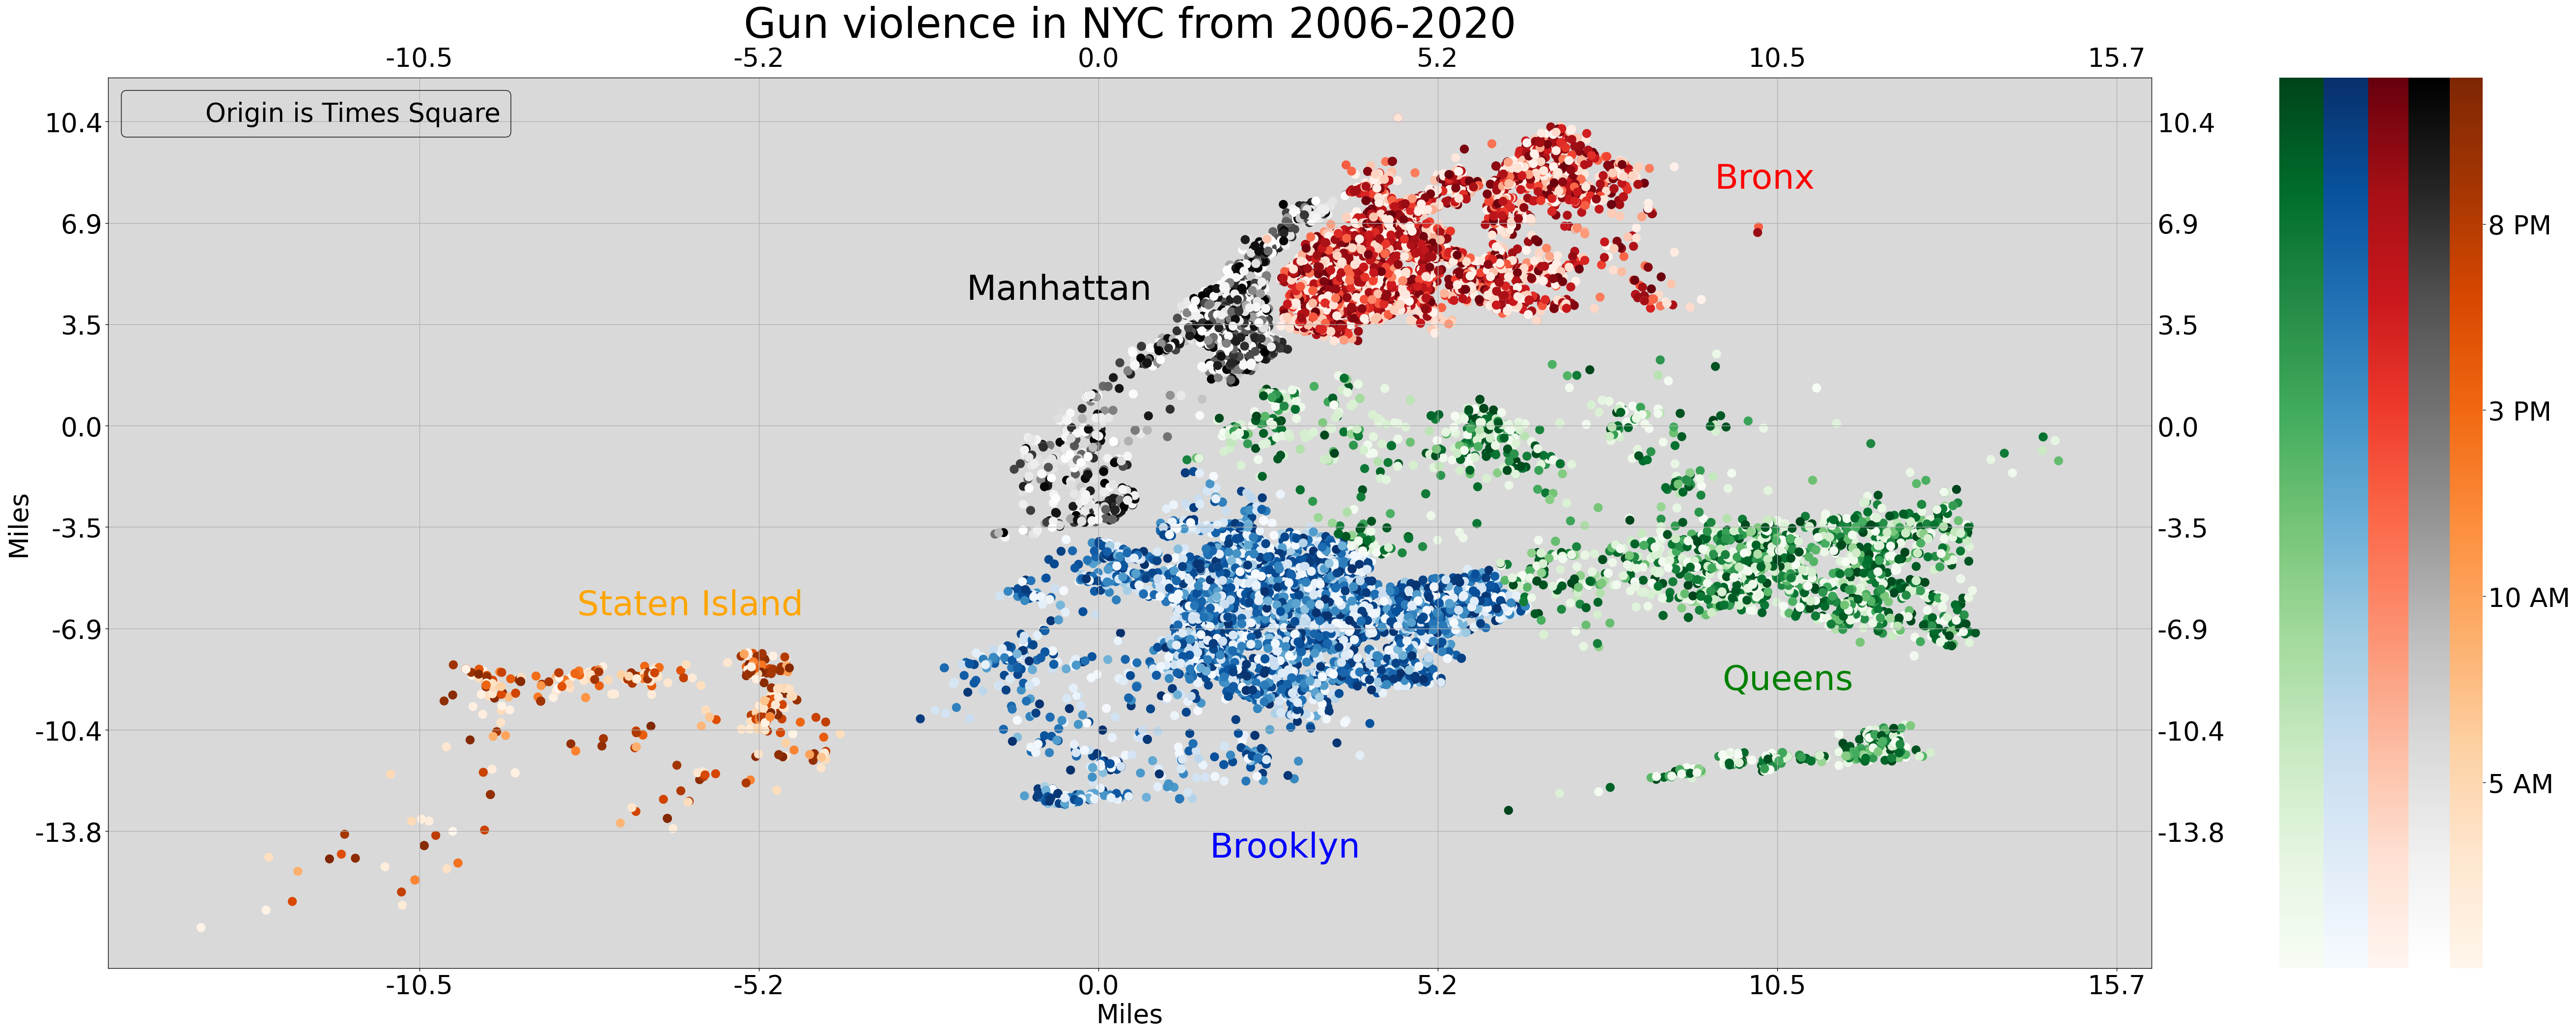

In [9]:
plotter1(data_in)

### find hotspots

In [10]:
# ## search for hotspots
# for loc in range(5):
#     search_hotspots(data_in[loc], sqmiles[loc][0]/sqmiles[loc][1], name_of[loc])
#     print(f"...found {name_of[loc]}.\n")

hotspots = [np.load(f"{root}/NYPD_{name}.npy", allow_pickle='TRUE').item() for name in name_of]

In [11]:
## filter the hotspots
filt_hot = []
for i, hotspot in enumerate(hotspots):
    out = filter_hotspots(data_in[i], hotspot, 2)
    filt_hot.append(out)

Mean: 27.165 || Standard Dev: 53.379
Mean: 34.544 || Standard Dev: 60.656
Mean: 85.049 || Standard Dev: 137.44
Mean: 193.088 || Standard Dev: 332.569
Mean: 60.746 || Standard Dev: 113.313


In [12]:
## triangulate the hotspots
data_out = []
for j, filtered in enumerate(filt_hot):
    out = triangulate_hotspots(name_of[j], filtered)
    data_out.append(out)

### visualize hotspots 

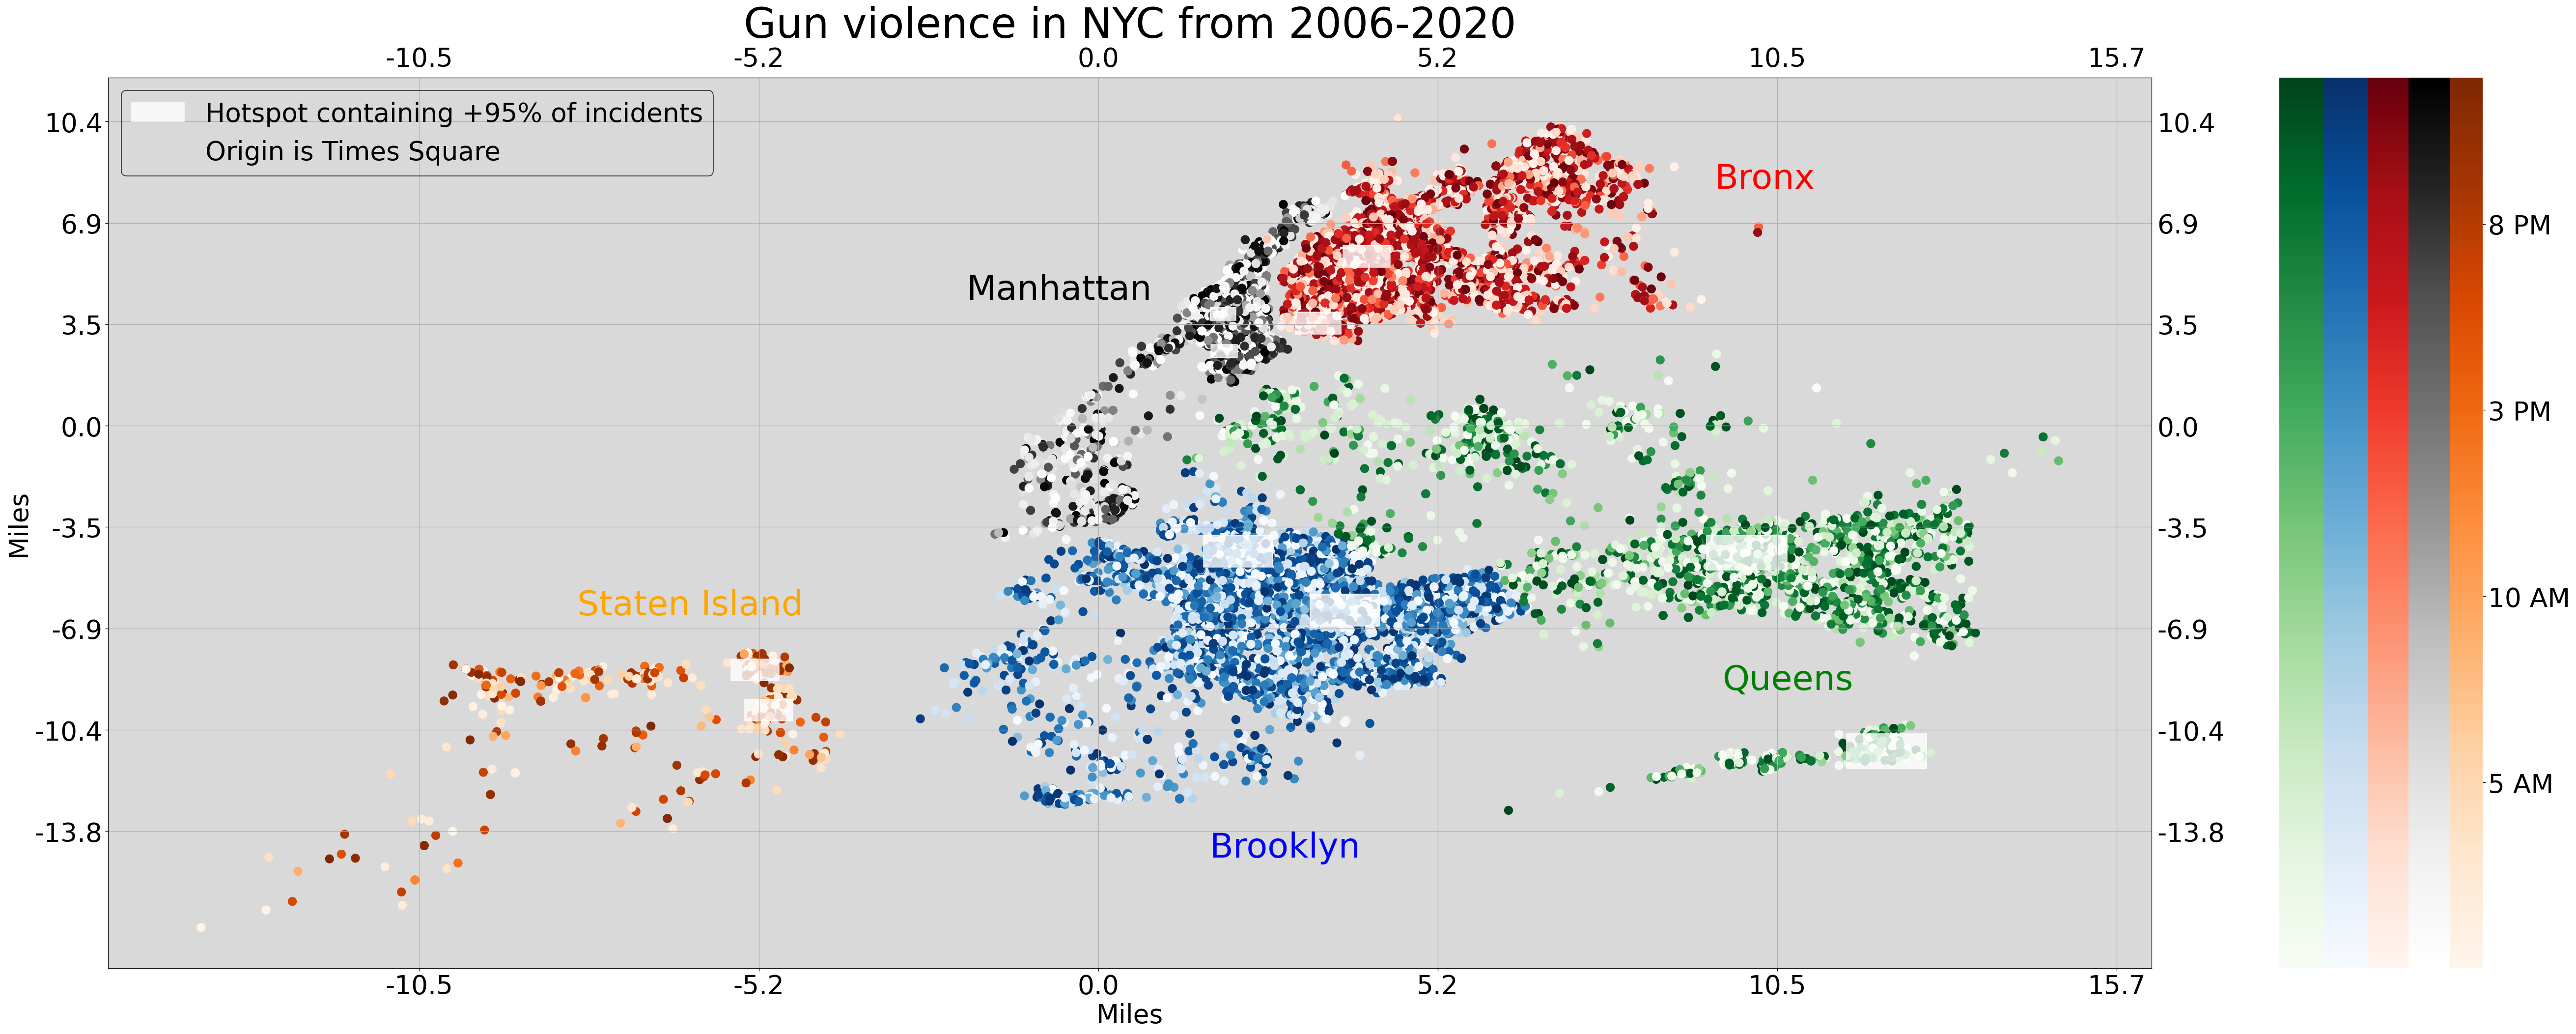

In [15]:
plotter1(data_in, False, hotspots=(data_out, sqmiles))

## ––––––––––––––––––––– task 2 ––––––––––––––––––––––

### define functions 

In [16]:
def life_n_death(dat):
    '''
    The # of shootings occurring within a certain time interval
    is calculated, including the amount that died and survived,
    and converted to a DataFrame.
    
    INPUT  : dat - DataFrame, shooting incident locations in a boro
    OUTPUT : out - DataFrame, amount of casualties in a boro
    '''
    occr, bins = np.histogram(dat.t_dec, bins=np.arange(0, 24.1, .25))
    hourly_int = {a:[] for a, b in enumerate(bins[:-1])} ## quarter hour intervals
    
    for hr in range(1, len(bins)):
        period = dat[(dat.t_dec >= bins[hr-1]) & (dat.t_dec < bins[hr])]
        
        te = len(period[period.Dead == True])            ## amount of deaths
        fe = len(period[period.Dead == False])           ## amount of survivors
        
        assert sum([te, fe]) == occr[hr-1]
        hourly_int[hr-1].append(te)
        hourly_int[hr-1].append(fe)
        try:
            hourly_int[hr-1].append((fe/(te+fe))*100)
        except ZeroDivisionError:                        ## if no data, 100% chance of living
            hourly_int[hr-1].append(100)
        hourly_int[hr-1].append(bins[hr-1])
    
    out = pd.DataFrame(hourly_int.values(), index=hourly_int.keys(), \
                       columns=['Died', 'Survived', 'frac', 't_dec'])

    times = []                                           ## convert decimal time to readable
    for _ in out.index:
        t = str(out.loc[_].t_dec)
        h = int(t[:t.find('.')])
        m = int(float(t[t.find('.'):])*60)

        if h > 12: h = h-12
        if h == 0: h = "12\nAM"
        if h == 12: h = "12\nPM"
        c = h
        times.append(c)
    
    out['t_disp'] = times
    return out

In [17]:
def demographic(dat):
    '''
    The amount of ethnicities involved each year (as perpetrators and victims)
    is counted and grouped into a DataFrame. nan and UNKNOWN values are merged.
    
    INPUT  :       dat - DataFrame, shooting incident locations in a boro
    OUTPUT : all_peeps - DataFrame, occurrence of all races involved
    '''
    all_races = []
    
    ## renaming nan column as NA for simplicity
    for _ in list(set(qs.Perp)):
        if type(_) is float: all_races.append('NA')
        else:                all_races.append(_)        

    all_peeps = {_:[] for _ in all_races}

    for yr in list(np.arange(2006, 2022, 1)):
        ppl_inv = {_:0 for _ in all_races}

        ## list of all perpetrator's and victim's races
        ppl = list(dat.Perp[dat.Year == yr]) + list(dat.Vic[dat.Year == yr])
        
        ## dictionary of occurrences of every race (normalized to %)
        for _ in set(ppl):
            if type(_) is float: ppl_inv['NA'] += (ppl.count(_)/len(ppl))*100
            else:                ppl_inv[_] += (ppl.count(_)/len(ppl))*100
                
        ## track the number of occurrences
        _ = [all_peeps[race].append(occr) for race, occr in ppl_inv.items()]
    
    ## group nan & UNKNOWN into one as per official footnotes
    all_peeps = pd.DataFrame(all_peeps)    
    all_peeps['Not Reported'] = all_peeps.NA + all_peeps.UNKNOWN
    all_peeps.drop(['NA', 'UNKNOWN'], axis=1, inplace=True)
    return all_peeps

In [18]:
def plotter2(i, sub, save=False):
    '''
    The amount of deaths and survivors for a given borough
    is plotted in a bar chart spanning 24 hours. A "survival rate"
    line is overplotted.
    
    INPUT  :    i -          int, counter for dataset
              sub -  AxesSubPlot, iteration in axes subplots
             save -      boolean, saved to Desktop if True
                
    OUTPUT : visual plot
    '''
    dat = life_n_death(data_in[i])

    p1 = dat.plot(y=['Died', 'Survived'], kind="bar", color=['red', 'blue'], width=1,\
                  legend=False, stacked=True, figsize=(100, 105), ax=sub)

    p2 = dat.plot(y='frac', ax=p1, sharex=p1, color='k', lw=5, mark_right=False,
                  legend=False, secondary_y=True)

    p1.set_title(f"{names_5[i]}")
    handles, labels = p1.get_legend_handles_labels()
    fig.legend(handles, labels, loc=9, ncol=3, bbox_to_anchor=(0.5, .96))
    _ = p1.set_xticklabels(dat['t_disp'], ha='left')
    _ = [b.set_visible(False) for a, b in enumerate(p1.xaxis.get_ticklabels()) if a % 4 != 0]
    
    if save: plt.savefig('/Users/saravi/Desktop/test2.png')
    return

In [19]:
def plotter3(i, sub, save=False):
    '''
    The amount of ethnicities involved over the years is
    plotted in a line graph.
    
    INPUT  :    i -          int, counter for dataset
              sub -  AxesSubPlot, iteration in axes subplots
             save -      boolean, saved to Desktop if True
                
    OUTPUT : visual plot
    '''
    dat = demographic(data_in[i])
    mkr = {a:b for a, b in zip(dat.keys(), ['^', 's', '*', 'h', '+', 'd', '.'])}
    
    for _ in dat:
        sub.plot(dat[_], marker=mkr[_], label=_, c='k', markersize=12)
        sub.tick_params(labelsize=25)
        sub.grid()
        sub.set_title(f"{names_5[i]}", fontsize=25)

    old_x_label = np.arange(0, 16, 2)
    new_x_label = np.arange(2006, 2022, 2)
    plt.xticks(old_x_label, new_x_label, fontsize=25)

    handles, labels = sub.get_legend_handles_labels()
    fig.legend(handles, labels, loc=9, ncol=3, bbox_to_anchor=(0.5, .95), fontsize=15)
    
    if save: plt.savefig('/Users/saravi/Desktop/test3.png')
    return

#### preliminary visualizations

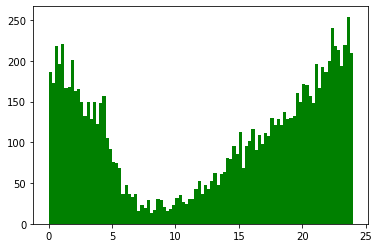

In [20]:
_ = plt.hist(bn.t_dec, np.arange(0, 24.1, .25), color='g')

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


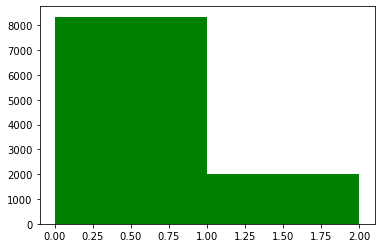

In [21]:
_ = plt.hist(bn.Dead, np.arange(3), color='g')

### visualize casualties against its rate

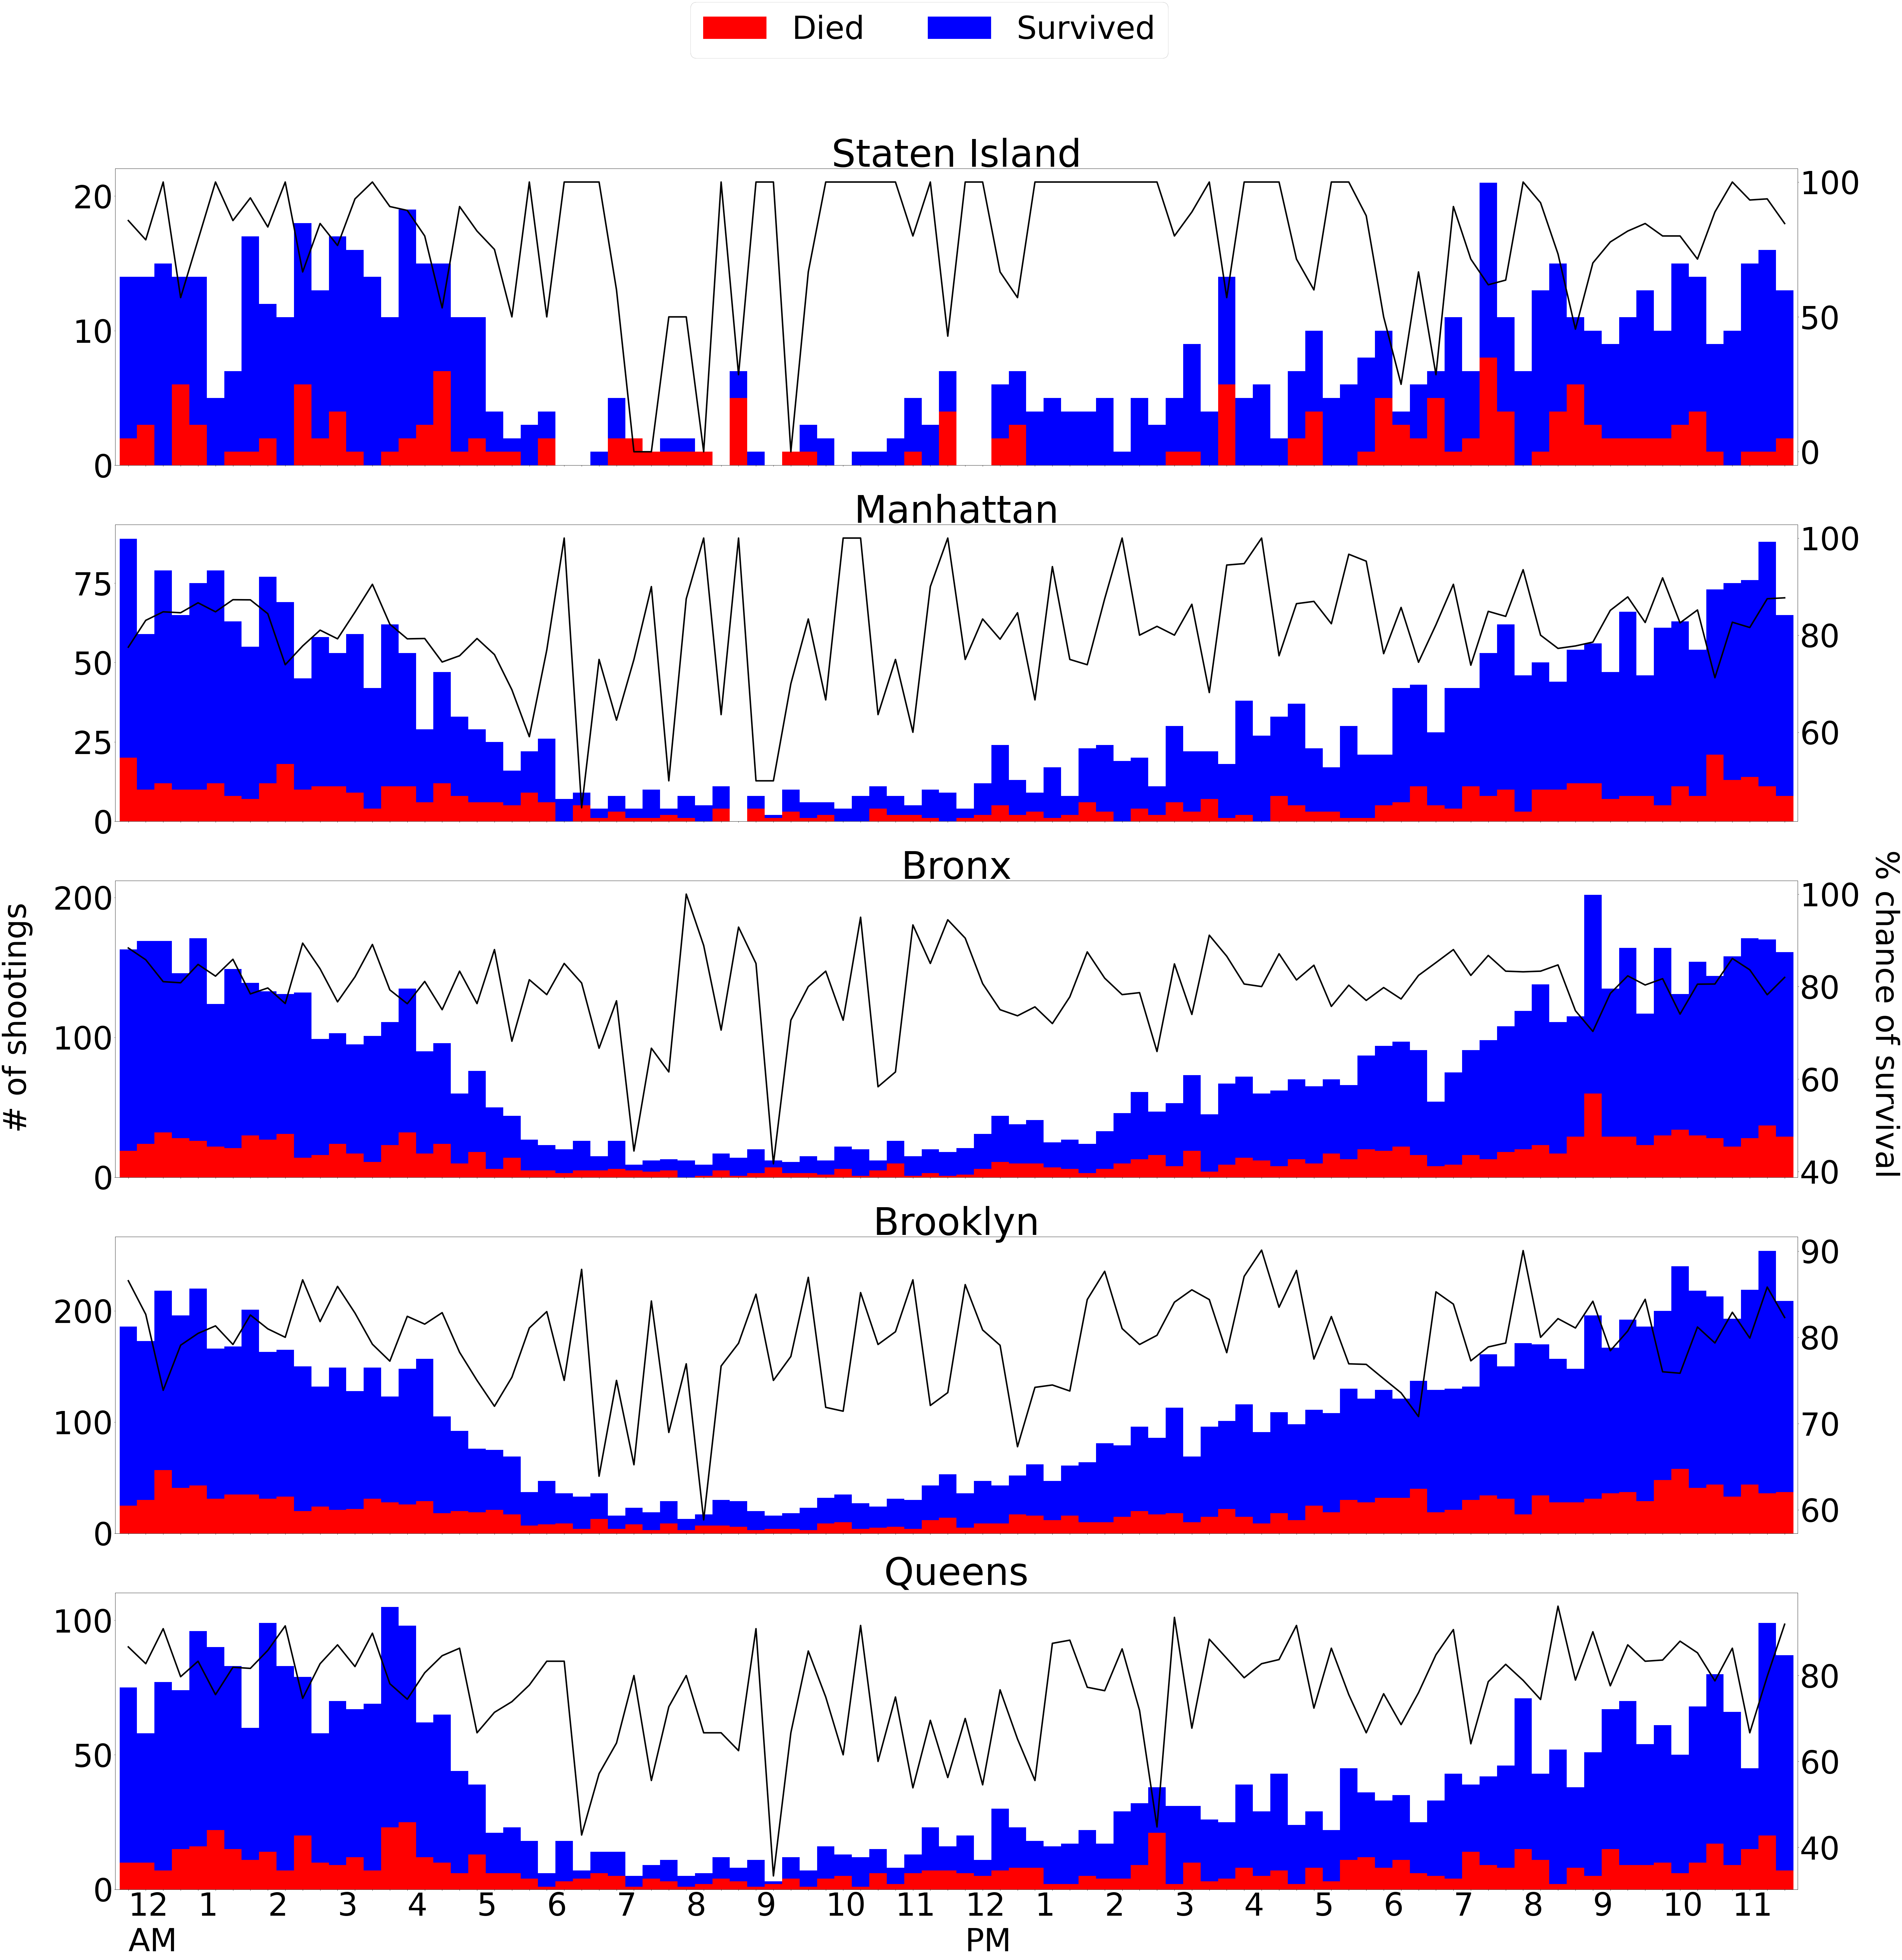

In [22]:
plt.rcParams.update({'font.size':105})
fig, axes = plt.subplots(5, 1)
fig.text(.08, 0.46, '# of shootings', ha='center', rotation=90)
fig.text(.94, 0.44, '% chance of survival', ha='center', rotation=270)

for a, b in enumerate(axes):
    plotter2(a, b, False)

### visualize the ethnicities involved over time 

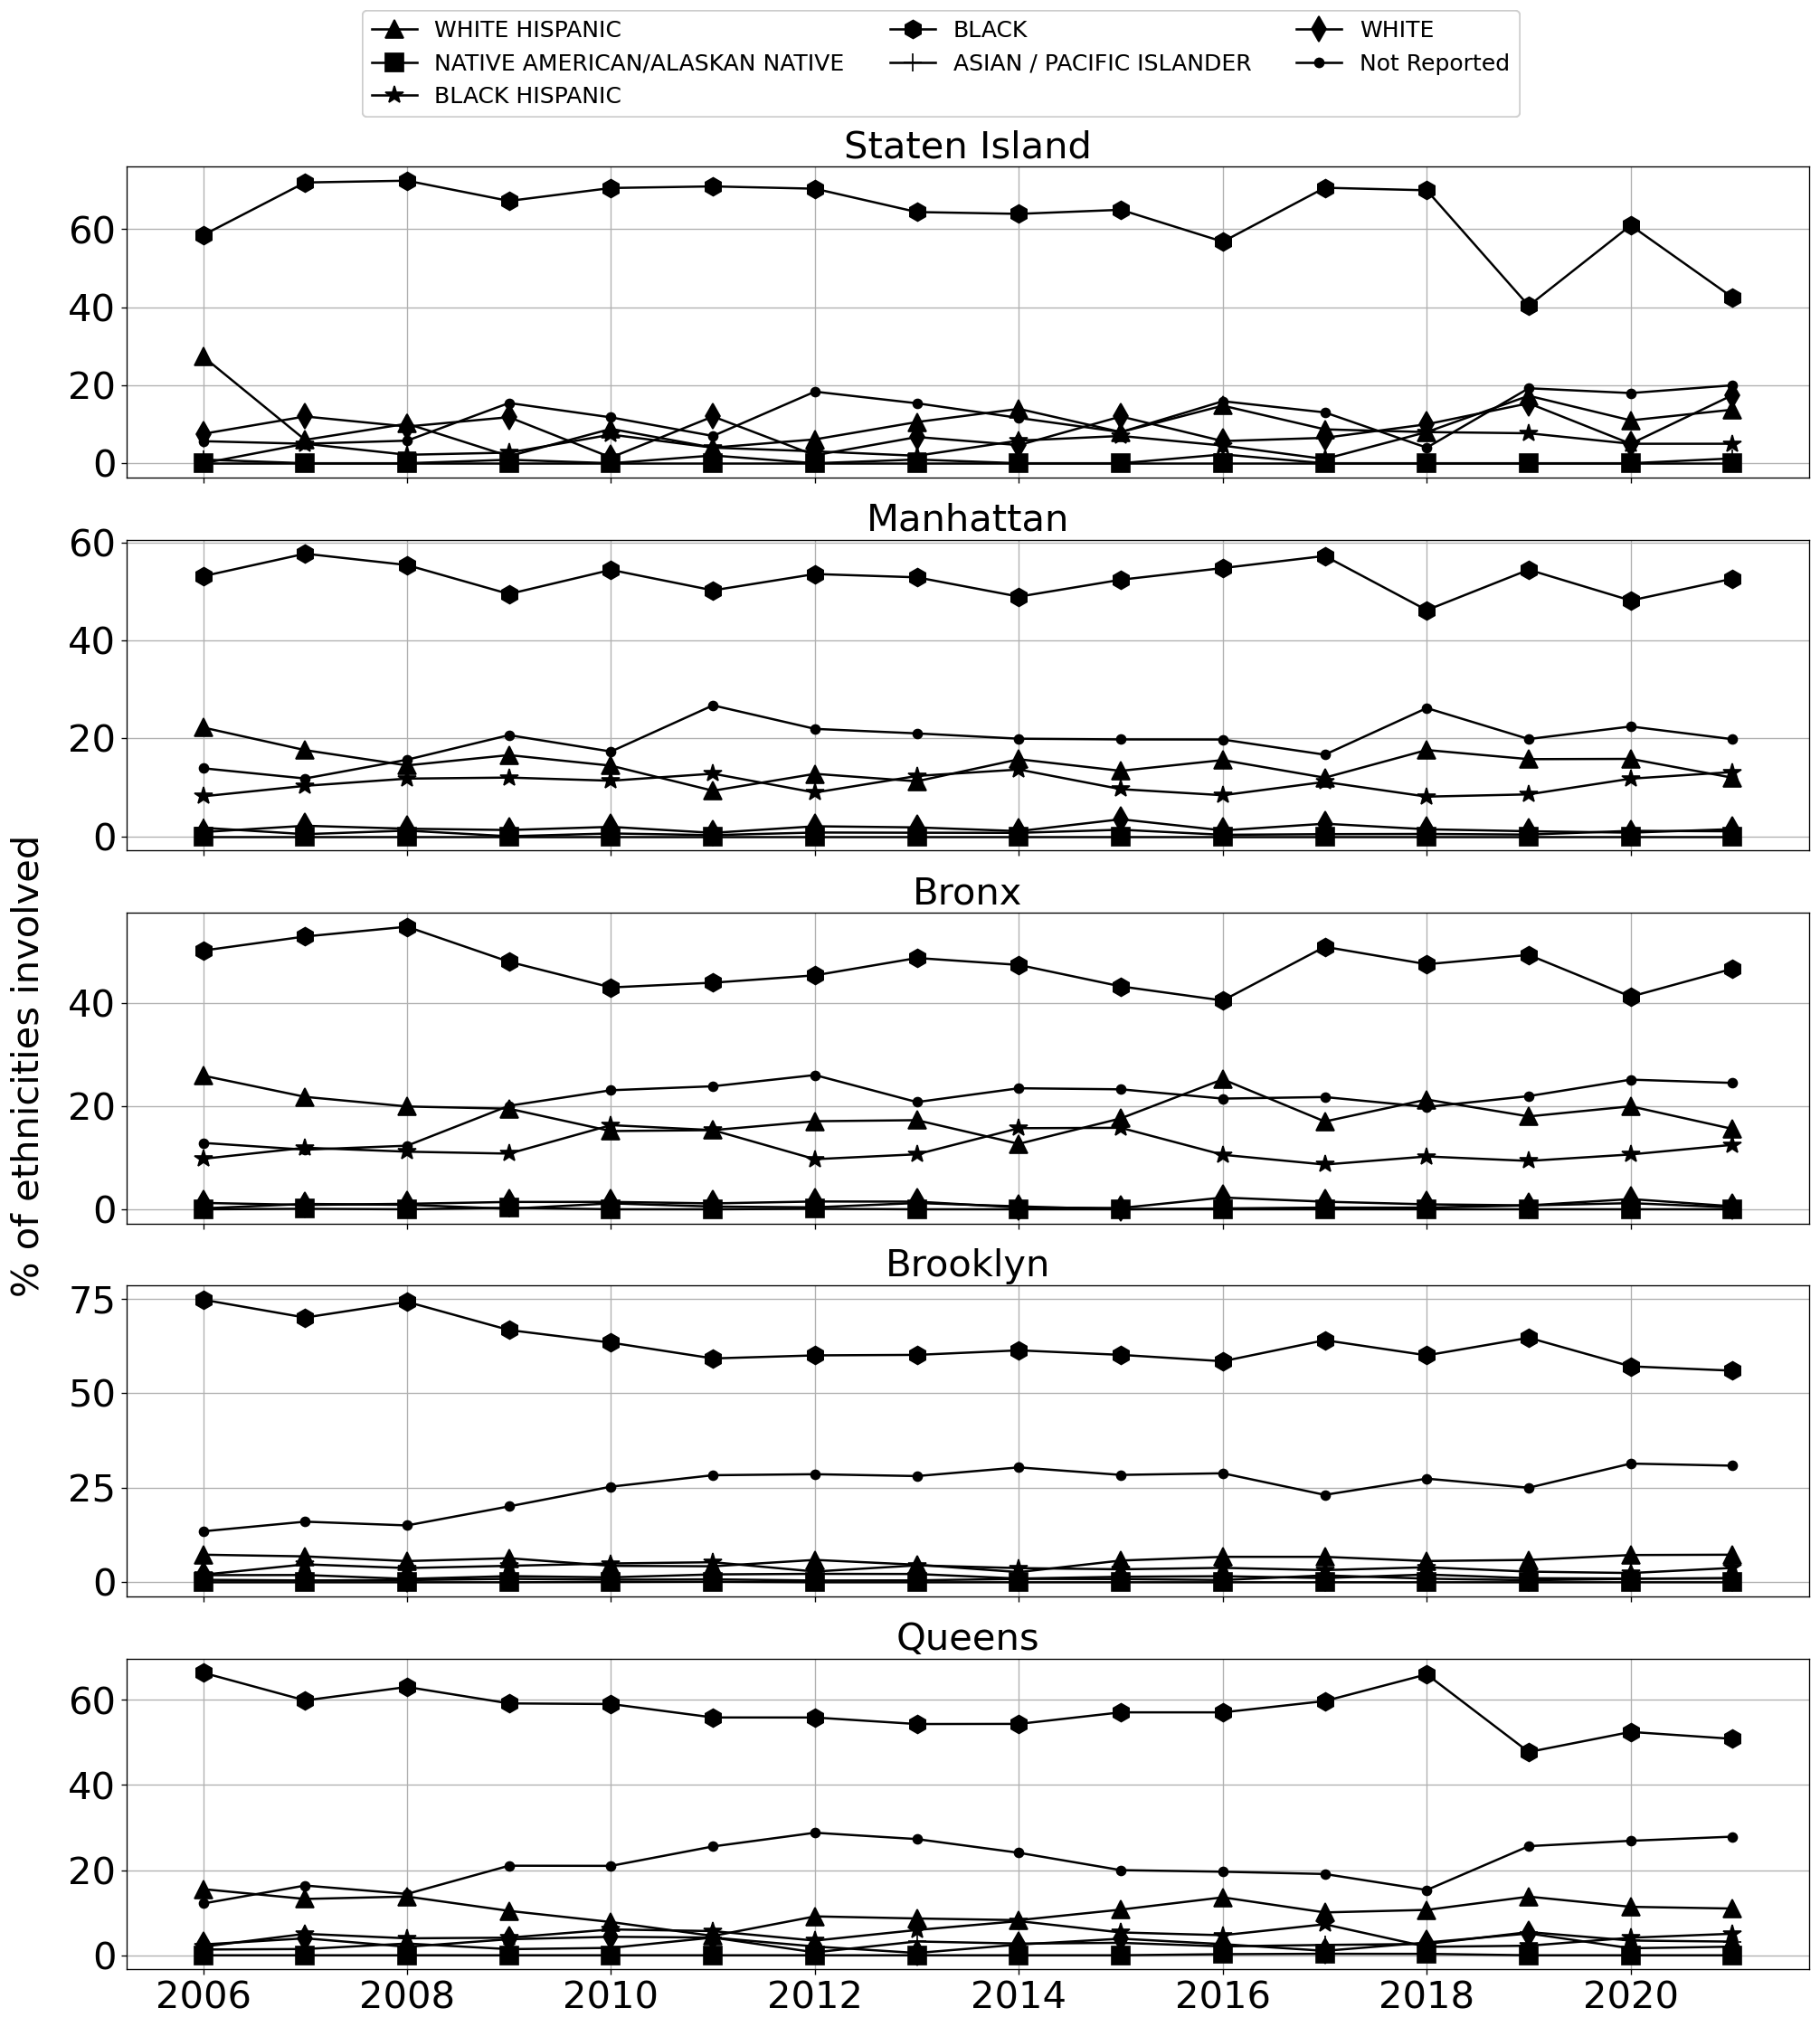

In [23]:
fig, axes = plt.subplots(5, 1, figsize=(20, 22), sharex=True, facecolor='1', dpi=120)
fig.text(.08, 0.41, '% of ethnicities involved', fontsize=25, ha='center', rotation=90)

for a, b in enumerate(axes):
    plotter3(a, b, False)